In [1]:
import os
import numpy as np
import pandas as pd
import zipfile


import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import metrics
from tensorflow.keras.models import Sequential

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
# Unzip all the zipped csv files using zipfile

with zipfile.ZipFile("/kaggle/input/jigsaw-toxic-comment-classification-challenge/train.csv.zip", "r") as f:
    f.extractall("/kaggle/working/")
    
with zipfile.ZipFile("/kaggle/input/jigsaw-toxic-comment-classification-challenge/test.csv.zip", "r") as f:
    f.extractall("/kaggle/working/")
    
with zipfile.ZipFile("/kaggle/input/jigsaw-toxic-comment-classification-challenge/test_labels.csv.zip", "r") as f:
    f.extractall("/kaggle/working/")

In [4]:
full_data_path = "/kaggle/working/train.csv"
test_data_X_path = "/kaggle/working/test.csv"
test_data_y_path = "/kaggle/working/test_labels.csv"

full_data = pd.read_csv(full_data_path)
test_data_X = pd.read_csv(test_data_X_path)
test_data_y = pd.read_csv(test_data_y_path)

In [5]:
full_data.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [6]:
print(f"There are {len(full_data)} observations in full data.")

There are 159571 observations in full data.


In [7]:
test_data_X.head()

,id,comment_text
0,00001cee341fdb12,Yo bitch Ja Rule is more succesful then you'll...
1,0000247867823ef7,== From RfC == \n\n The title is fine as it is...
2,00013b17ad220c46,""" \n\n == Sources == \n\n * Zawe Ashton on Lap..."
3,00017563c3f7919a,":If you have a look back at the source, the in..."
4,00017695ad8997eb,I don't anonymously edit articles at all.


In [8]:
test_data_y.head()

,id,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,00001cee341fdb12,-1,-1,-1,-1,-1,-1
1,0000247867823ef7,-1,-1,-1,-1,-1,-1
2,00013b17ad220c46,-1,-1,-1,-1,-1,-1
3,00017563c3f7919a,-1,-1,-1,-1,-1,-1
4,00017695ad8997eb,-1,-1,-1,-1,-1,-1


In [9]:
# Merging the X and y part together
test_dataframe = pd.merge(test_data_X, test_data_y, how="inner", on="id")

# Remove all the rows having missing values (-1)
test_dataframe = test_dataframe[test_dataframe["toxic"] != -1].reset_index(drop=True)

test_dataframe.sample(5) 

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
2439,09e241d405ba3644,":Sheeesh, that's among the weirdest shite I've...",0,0,0,0,0,0
16008,3fbcb2af299510ff,==Mississippi Baptist Convention Board== \n\n ...,0,0,0,0,0,0
47788,be5e979e41c1fbc1,""" \n :Well...that conversation certainly took ...",0,0,0,0,0,0
55717,de68194093f9d6ac,why did you just delete my aritle on israeli s...,0,0,0,0,0,0
27629,6e2cd03393176720,List of films featuring time loops \n Please ...,0,0,0,0,0,0


In [10]:
print(f"We have {len(test_dataframe)} observations in test data.")

We have 63978 observations in test data.


In [11]:
del test_data_X
del test_data_y

In [12]:
full_data.columns

Index(['id', 'comment_text', 'toxic', 'severe_toxic', 'obscene', 'threat',
       'insult', 'identity_hate'],
      dtype='object')

In [13]:
full_data["comment_text"].values

array(["Explanation\nWhy the edits made under my username Hardcore Metallica Fan were reverted? They weren't vandalisms, just closure on some GAs after I voted at New York Dolls FAC. And please don't remove the template from the talk page since I'm retired now.89.205.38.27",
       "D'aww! He matches this background colour I'm seemingly stuck with. Thanks.  (talk) 21:51, January 11, 2016 (UTC)",
       "Hey man, I'm really not trying to edit war. It's just that this guy is constantly removing relevant information and talking to me through edits instead of my talk page. He seems to care more about the formatting than the actual info.",
       ...,
       'Spitzer \n\nUmm, theres no actual article for prostitution ring.  - Crunch Captain.',
       'And it looks like it was actually you who put on the speedy to have the first version deleted now that I look at it.',
       '"\nAnd ... I really don\'t think you understand.  I came here and my idea was bad right away.  What kind of communit

In [14]:
full_data[['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']].values

array([[0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       ...,
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0]])

In [15]:
# Convert the dataframes into tensorflow Dataset objects

train_data = tf.data.Dataset.from_tensor_slices(
    (
        full_data["comment_text"].tolist(), 
        full_data[['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']].values.tolist()
    )
)

test_data = tf.data.Dataset.from_tensor_slices(
    (
        test_dataframe["comment_text"].tolist(), 
        test_dataframe[['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']].values.tolist()
    )
)

In [16]:
batch_size = 16

train_data = train_data.cache().shuffle(1024).batch(batch_size).prefetch(tf.data.AUTOTUNE)
test_data = test_data.cache().batch(batch_size)

In [17]:
max_tokens = 100000


text_vectorization = layers.TextVectorization(
    max_tokens=max_tokens,
    standardize='lower_and_strip_punctuation',
    output_mode="int",
    output_sequence_length=1800
)

text_vectorization.adapt(full_data["comment_text"].tolist())


In [18]:
# Remove the unnecessary data

del full_data
del test_dataframe

In [19]:
model = Sequential([
    text_vectorization,
    layers.Embedding(max_tokens+1, 32),
    layers.Bidirectional(layers.LSTM(32, return_sequences=False)),
    layers.Dense(256, activation="relu"),
    layers.Dense(256, activation="relu"),
    layers.Dense(128, activation="relu"),
    layers.Dense(6, activation="sigmoid")
])

In [20]:
model.compile(
    optimizer="adam",
    loss="binary_crossentropy",
    metrics=metrics.BinaryAccuracy()
)

In [21]:
train_split = 0.8

train_data = train_data.take(int(len(train_data) * train_split))
valid_data = train_data.skip(int(len(train_data) * train_split))

In [22]:
callbacks = [
    keras.callbacks.EarlyStopping(
        monitor="val_loss",
        patience=5, 
        restore_best_weights=True, 
        start_from_epoch=1, 
        verbose=1
    ),
    keras.callbacks.ReduceLROnPlateau(
        monitor="val_loss", 
        factor=0.5, 
        patience=3, 
        verbose=1, 
        min_lr=1e-6
    )
]

In [25]:
model_history = model.fit(
    train_data,
    epochs=15,
    verbose=1,
    callbacks=callbacks,
    validation_data=valid_data
).history

Epoch 1/15
7979/7979 [==============================] - 717s 90ms/step - loss: 0.0315 - binary_accuracy: 0.9877 - val_loss: 0.0346 - val_binary_accuracy: 0.9898 - lr: 0.0010
Epoch 2/15
7979/7979 [==============================] - 718s 90ms/step - loss: 0.0280 - binary_accuracy: 0.9891 - val_loss: 0.0243 - val_binary_accuracy: 0.9914 - lr: 0.0010
Epoch 3/15
7979/7979 [==============================] - 723s 91ms/step - loss: 0.0242 - binary_accuracy: 0.9908 - val_loss: 0.0213 - val_binary_accuracy: 0.9930 - lr: 0.0010
Epoch 4/15
7979/7979 [==============================] - 726s 91ms/step - loss: 0.0209 - binary_accuracy: 0.9921 - val_loss: 0.0172 - val_binary_accuracy: 0.9941 - lr: 0.0010
Epoch 5/15
7979/7979 [==============================] - 726s 91ms/step - loss: 0.0182 - binary_accuracy: 0.9932 - val_loss: 0.0153 - val_binary_accuracy: 0.9947 - lr: 0.0010
Epoch 6/15
7979/7979 [==============================] - 726s 91ms/step - loss: 0.0161 - binary_accuracy: 0.9940 - val_loss: 0.0153

In [26]:
model.evaluate(test_data)

3999/3999 [==============================] - 154s 39ms/step - loss: 0.1899 - binary_accuracy: 0.9505


[0.1899225413799286, 0.9505350589752197]

In [28]:
import matplotlib.pyplot as plt

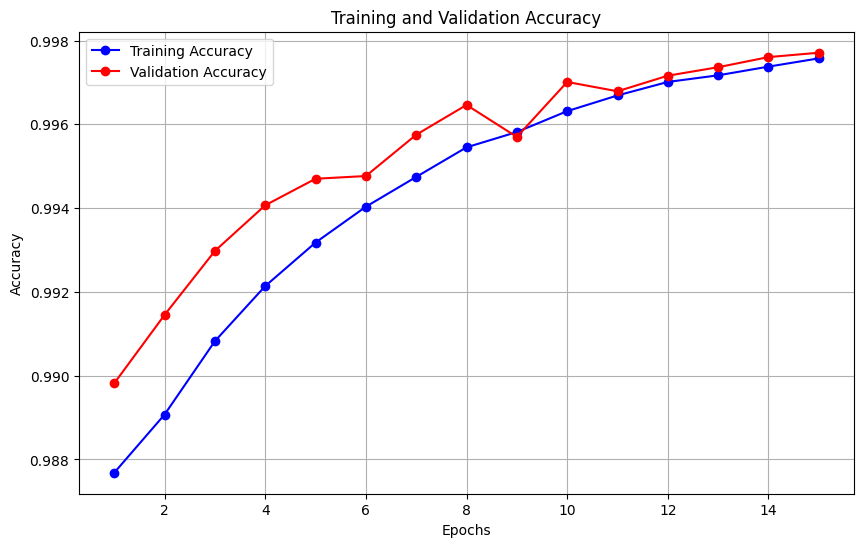

In [32]:
train_accuracy = model_history['binary_accuracy']
val_accuracy = model_history['val_binary_accuracy']

# Creating a range of epochs for x-axis
epochs = range(1, len(train_accuracy) + 1)

plt.figure(figsize=(10, 6))
plt.plot(epochs, train_accuracy, 'bo-', label='Training Accuracy')
plt.plot(epochs, val_accuracy, 'ro-', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

In [33]:
model.save('toxicity', save_format='tf')

In [27]:
text = "I am going to kill you"
predictions = model.predict(np.array([text])) > 0.5
prediction_text = ""
for i, col in enumerate(['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']):
    prediction_text += f"{col:<{20}}: {predictions[0][i]:<{5}}\n"
print(prediction_text)

1/1 [==============================] - 1s 893ms/step
toxic               : 1    
severe_toxic        : 1    
obscene             : 0    
threat              : 1    
insult              : 0    
identity_hate       : 0    

